## Loading of Miller ECoG data of faces/houses (+ noise)

includes some visualizations

In [1]:
#@title Data retrieval
import os, requests

fname = 'faceshouses.npz'
url = "https://osf.io/argh7/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [2]:
#@title Install packages, import matplotlib and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet

from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

     |████████████████████████████████| 4.9 MB 4.4 MB/s 
     |████████████████████████████████| 399 kB 4.4 MB/s 
     |████████████████████████████████| 2.7 MB 49.4 MB/s 


In [3]:
#@title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

# select just one of the recordings here. 
dat1 = alldat[5][0]# subject 1, block 0
dat2 = alldat[5][1]# sub0,2,3,4,5,6 have key press

print(dat1.keys())
print(dat2.keys())

dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])
dict_keys(['stim_id', 'stim_cat', 'stim_noise', 't_on', 't_off', 'key_press', 'V', 'categories', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


# Dataset info #

This is one of multiple ECoG datasets from Miller 2019, recorded in a clinical settings with a variety of tasks. We plan to curate a few more before NMA starts. Raw data here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522

`alldat` contains 7 subjects each with two sessions `dat1` and `dat2`, and was originally used in these publications: 

*Miller, Kai J., et al. "Face percept formation in human ventral temporal cortex." Journal of neurophysiology 118.5 (2017): 2614-2627.*

*Miller, Kai J., et al. "The physiology of perception in human temporal lobe is specialized for contextual novelty." Journal of neurophysiology 114.1 (2015): 256-263.*

*Miller, Kai J., et al. "Spontaneous decoding of the timing and content of human object perception from cortical surface recordings reveals complementary information in the event-related potential and broadband spectral change." PLoS computational biology 12.1 (2016): e1004660.*

*Miller, Kai J., et al. "The physiology of perception in human temporal lobe is specialized for contextual novelty." Journal of neurophysiology 114.1 (2015): 256-263.*

*Miller, Kai J., et al. "Spontaneous decoding of the timing and content of human object perception from cortical surface recordings reveals complementary information in the event-related potential and broadband spectral change." PLoS computational biology 12.1 (2016): e1004660.*

In this task, subjects in a clinical settings (with ECoG implants) are passively shown faces and house during the first experiment (`dat1`). Then in the second experiment in the same subjects (`dat2`), noise is added to face and houses images and the subject has to detect the faces by pressing a key. Two of the subjects don't have keypresses. 

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across time and conversion to float16 to minimize size. 

Experiment 2: 
* `dat2['V`]: continuous voltage data (time by channels)
* `dat2['srate']`: acquisition rate (1000 Hz). All stimulus times are in units of this.  
* `dat2['t_on']`: time of stimulus onset in data samples
* `dat2['t_off']`: time of stimulus offset, always 1000 samples after `t_on`, with no inter-stimulus interval
* `dat2['stim_id`]: identity of stimulus from 1-600 (not really useful, since we don't know which ones are the same house/face)
* `dat2['stim_cat']`: stimulus category (1 = house, 2 = face)
* `dat2['stim_noise']`: percent noise from 0 to 100
* `dat2['key_press']`: when the subject thought the image was a face
* `dat2['categories']`: categories legend (1 = house, 2 = face)
* `dat2['locs`]: 3D electrode positions on the brain surface


In [4]:
#@title localizer
# quick way to get broadband power in time-varying windows
from scipy import signal

V = dat1['V'].astype('float32')

b, a = signal.butter(3, [50], btype = 'high', fs=1000) # ????
V = signal.filtfilt(b,a,V,0)
V = np.abs(V)**2
b, a = signal.butter(3, [10], btype = 'low', fs=1000) # ????
V = signal.filtfilt(b,a,V,0)

V = V/V.mean(0)

In [5]:
# average the broadband power across all face stimuli and across all house stimuli

nt, nchan = V.shape
nstim = len(dat1['t_on'])

trange = np.arange(-200, 400)
ts = dat1['t_on'][:,np.newaxis] + trange
V_epochs = np.reshape(V[ts, :], (nstim, 600, nchan))

V_house = (V_epochs[dat1['stim_id']<=50]).mean(0)
V_face  = (V_epochs[dat1['stim_id']>50]).mean(0)

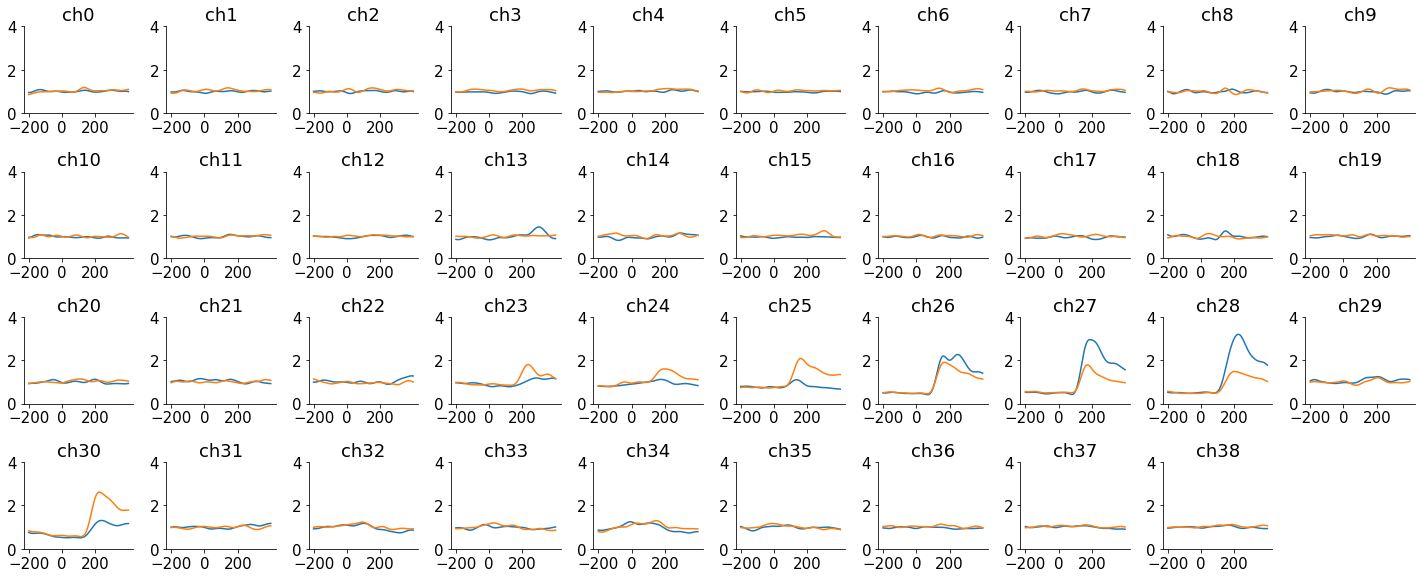

In [6]:
# let's find the electrodes that distinguish faces from houses
from matplotlib import pyplot as plt

locs = dat2['locs']
plt.figure(figsize=(20,10))
for j in range(len(locs)):
  ax = plt.subplot(5,10,j+1)
  plt.plot(trange, V_house[:,j])
  plt.plot(trange, V_face[:,j])
  plt.title('ch%d'%j)
  plt.xticks([-200, 0, 200])
  plt.ylim([0, 4])

Use sub[5] and chan 30 for face, chan 28 for house

In [7]:
#@title Experimental data - location
from nilearn import plotting  
from nimare import utils

plt.figure(figsize=(8,8))
locs = dat2['locs']
view = plotting.view_markers(utils.tal2mni(locs), marker_labels  = ['%d'%k for k in np.arange(locs.shape[0])], marker_color = 'purple', marker_size=5)
view

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)
ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


<Figure size 576x576 with 0 Axes>

In [8]:
# quick way to get broadband power in time-varying windows
from scipy import signal

V = dat2['V'].astype('float32')

b, a = signal.butter(3, [50], btype = 'high', fs=1000) # ????
V = signal.filtfilt(b,a,V,0)
V = np.abs(V)**2
b, a = signal.butter(3, [10], btype = 'low', fs=1000) # ????
V = signal.filtfilt(b,a,V,0)

V = V/V.mean(0)

In [9]:
# select face and house trials from -200 to 400 ms

nt, nchan = V.shape
nstim = len(dat2['t_on'])

trange = np.arange(-200, 400)
ts = dat2['t_on'][:,np.newaxis] + trange
V_epochs = np.reshape(V[ts, :], (nstim, 600, nchan))

index_h = dat2['stim_cat']==1
index_f = dat2['stim_cat']==2

V_house = V_epochs[index_h.ravel()]
V_face  = V_epochs[index_f.ravel()]

In [10]:
# average the broadband power across all face and house trials
V_house_avg = V_house.mean(0)
V_face_avg  = V_face.mean(0)

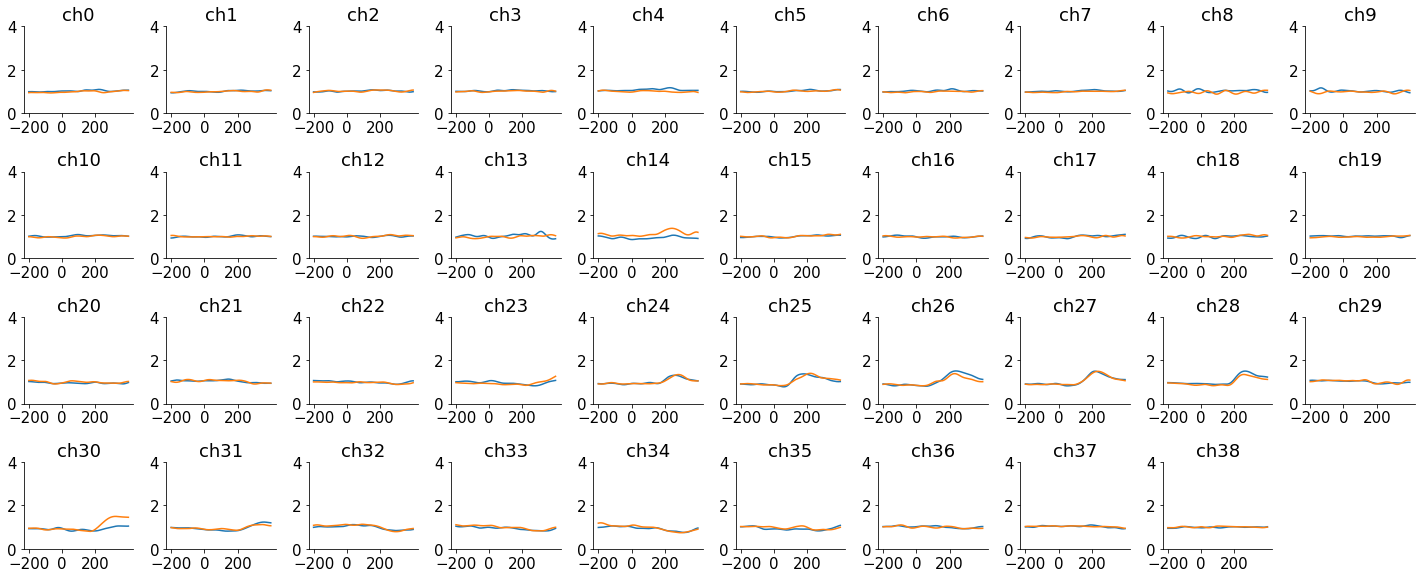

In [11]:
#@title Experimental data - Power by location
# let's find the electrodes that distinguish faces from houses
from matplotlib import pyplot as plt

plt.figure(figsize=(20,10))
for j in range(len(locs)):
  ax = plt.subplot(5,10,j+1)
  plt.plot(trange, V_house_avg[:,j])
  plt.plot(trange, V_face_avg[:,j])
  plt.title('ch%d'%j)
  plt.xticks([-200, 0, 200])
  plt.ylim([0, 4])
  

# The effect of noise

In [12]:
# sort the stimuli according to the noise level
index_noise = dat2['stim_noise'].ravel()
#index_noise_h = index_noise[index_h.ravel()]
index_noise_f = index_noise[index_f.ravel()]

noise_level = [k for k in range(0,105,5)]
V_face_noise_f = {}
V_face_noise_h = {}
keys = range(len(noise_level))
for i in keys:
  temp_f = index_noise_f==noise_level[i]
  V_face_noise_f[i] = V_face[temp_f,:,30]
  #temp_h = index_noise_h==noise_level[i]
  V_face_noise_h[i] = V_face[temp_f,:,28]

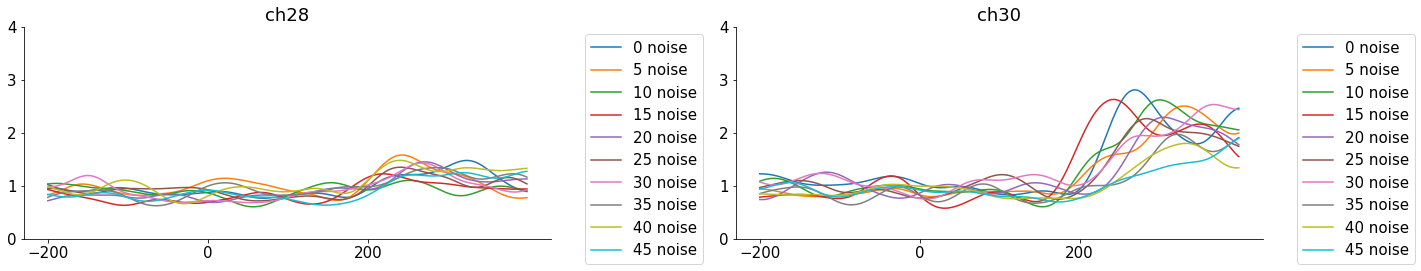

In [13]:
# plot V according to noise level: 0-45%

chan = [28, 30]
for j in range(2):
  ax = plt.subplot(1,2,j+1)
  if j == 0:
    for k in range(10):
      m = k*5
      plt.plot(trange, V_face_noise_h[k].mean(axis = 0), label='%s noise'%m)
  else:
    for k in range(10):
      m = k*5
      plt.plot(trange, V_face_noise_f[k].mean(axis = 0), label='%s noise'%m)
  plt.title('ch%d'%chan[j])
  plt.xticks([-200, 0, 200])
  plt.ylim([0, 4])
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

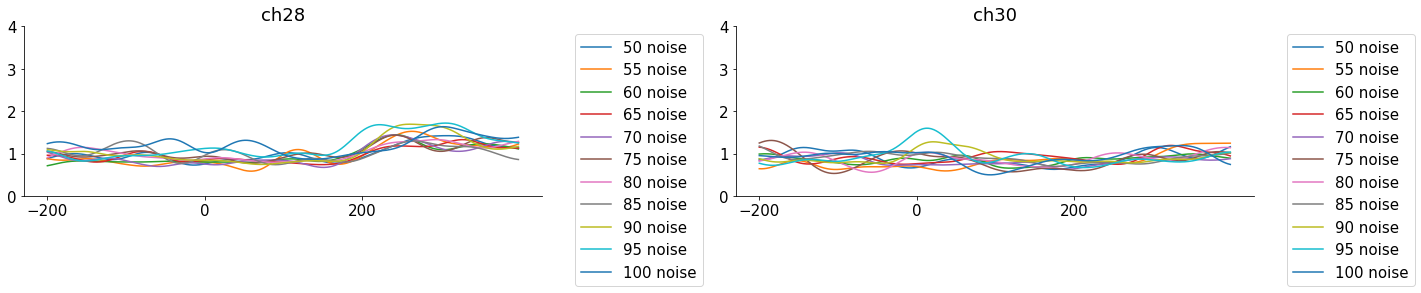

In [14]:
# plot V according to noise level: 50-100%

chan = [28, 30]
for j in range(2):
  ax = plt.subplot(1,2,j+1)
  if j == 0:
    for k in range(10,21):
      m = k*5
      plt.plot(trange, V_face_noise_h[k].mean(axis = 0), label='%s noise'%m)
  else:
    for k in range(10,21):
      m = k*5
      plt.plot(trange, V_face_noise_f[k].mean(axis = 0), label='%s noise'%m)
  plt.title('ch%d'%chan[j])
  plt.xticks([-200, 0, 200])
  plt.ylim([0, 4])
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [15]:
#@title Experimental data in three noise levels
V_face_noise_h[0].shape[0]
test = [[None for x in range(6)] for y in range(6)]
#test

In [16]:
for i in keys:
  print(V_face_noise_f[i].shape[0], end='-')
print(end='\n')
#for i in keys:
#  print(V_house_noise[i].shape[0], end='-')

V_face_noise1_h = V_face_noise_h[0]
V_face_noise2_h = V_face_noise_h[7]
V_face_noise3_h = V_face_noise_h[14]

V_face_noise1_f = V_face_noise_f[0]
V_face_noise2_f = V_face_noise_f[7]
V_face_noise3_f = V_face_noise_f[14]
for k in range(1,7):
  #print(V_face_noise_h.shape[0])
  V_face_noise1_h = np.concatenate((V_face_noise1_h,V_face_noise_h[k]),axis=0)
  V_face_noise2_h = np.concatenate((V_face_noise2_h,V_face_noise_h[k+7]),axis=0)
  V_face_noise3_h = np.concatenate((V_face_noise3_h,V_face_noise_h[k+14]),axis=0)

  V_face_noise1_f = np.concatenate((V_face_noise1_f,V_face_noise_f[k]),axis=0)
  V_face_noise2_f = np.concatenate((V_face_noise2_f,V_face_noise_f[k+7]),axis=0)
  V_face_noise3_f = np.concatenate((V_face_noise3_f,V_face_noise_f[k+14]),axis=0)



15-15-17-15-15-15-15-15-15-15-15-15-15-15-15-15-15-15-15-15-13-


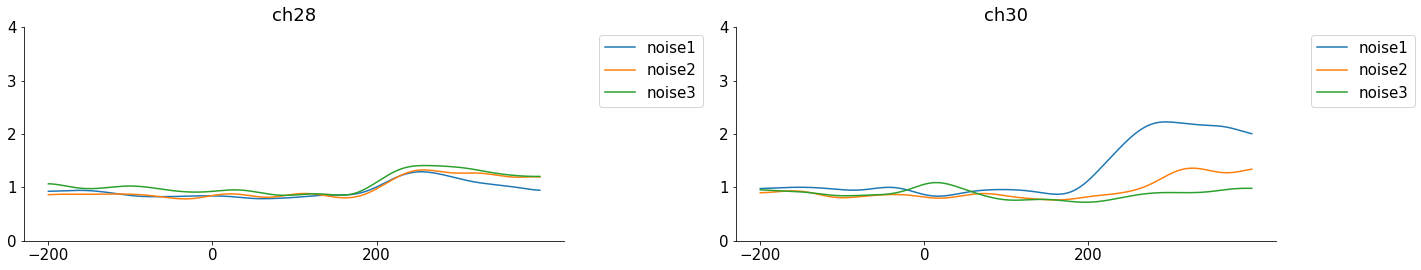

In [17]:
# plot V according to 3 noise levels

chan = [28, 30]
for j in range(2):
  ax = plt.subplot(1,2,j+1)
  if j == 0:
    plt.plot(trange, V_face_noise1_h.mean(axis = 0),label='noise1')
    plt.plot(trange, V_face_noise2_h.mean(axis = 0),label='noise2')
    plt.plot(trange, V_face_noise3_h.mean(axis = 0),label='noise3')
  else:
    plt.plot(trange, V_face_noise1_f.mean(axis = 0),label='noise1')
    plt.plot(trange, V_face_noise2_f.mean(axis = 0),label='noise2')
    plt.plot(trange, V_face_noise3_f.mean(axis = 0),label='noise3')
  plt.title('ch%d'%chan[j])
  plt.xticks([-200, 0, 200])
  plt.ylim([0, 4])
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [18]:
# matlab find
def indices(a, func):
    return [i for (i, val) in enumerate(a) if func(val)]

In [19]:
## Data classification
#toff = dat2['t_on']
#keypress = dat2['key_press']

## find toff == keypress
##test = ismember(toff,keypress)
##test.count(1)
##indices(test,lambda x: x == 1)

#KeyFace_all = []
#for k in range(len(keypress)):
#  temp = toff - keypress[k]
#  result = temp[(temp<-200)*(temp>-1200)]
#  if len(result) == 1:
#    KeyFace = indices(temp, lambda x: x == result)
#    KeyFace_all += KeyFace

#indx_f_temp = index_f.ravel()
#true_indx_f = [i for i, x in enumerate(indx_f_temp) if x] # find true in indx_f_temp
#f_and_keyf_indx = np.in1d(true_indx_f,KeyFace_all)
#true_f_and_keyf_indx = [i for i, x in enumerate(f_and_keyf_indx) if x] # find true in f_and_keyf_indx
#true_indx_f = np.array(true_indx_f)

#V_face_keyface  = V_epochs[true_indx_f[true_f_and_keyf_indx]]
#V_face_keyno = V_epochs[np.delete(true_indx_f,true_f_and_keyf_indx)]

#index_noise = dat2['stim_noise'].ravel()
#index_noise_h = index_noise[index_h.ravel()]
#index_noise_f = index_noise[index_f.ravel()]

In [20]:
#@title get keypress

In [21]:
idx = 0
key_pressed_in = []
rts = []
for i, t in enumerate(dat2["t_on"]):
    if idx == len(dat2["key_press"]):
        break
    if (t + 200) > dat2["key_press"][idx]:
        idx += 1
    elif (t + 200) <= dat2["key_press"][idx] <=(t + 1200):
        key_pressed_in.append(i)
        rts.append(dat2["key_press"][idx] - t)
        idx += 1

In [22]:
# double check
print(dat2['key_press'][0:5])
print(dat2['t_on'][0:11])
print(dat2['t_off'][0:11])
print(key_pressed_in)

[ 7000  8480 10560 12960 14160]
[ 3080  5080  6080  7080  8080  9080 10080 11080 12080 13080 14080]
[ 4080  6080  7080  8080  9080 10080 11080 12080 13080 14080 15080]
[2, 4, 6, 8, 9, 10, 12, 15, 18, 23, 25, 26, 27, 28, 31, 32, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 53, 54, 56, 58, 63, 64, 65, 72, 73, 74, 75, 77, 78, 80, 82, 84, 86, 89, 92, 93, 94, 99, 100, 101, 102, 112, 113, 114, 115, 116, 120, 123, 124, 127, 131, 133, 135, 136, 137, 139, 141, 142, 143, 146, 148, 149, 150, 154, 155, 156, 158, 159, 164, 166, 167, 170, 171, 172, 173, 174, 175, 177, 178, 181, 182, 183, 185, 187, 188, 189, 191, 192, 194, 196, 198, 199, 200, 201, 202, 203, 204, 208, 210, 211, 212, 213, 215, 217, 219, 220, 221, 225, 228, 231, 233, 234, 237, 240, 241, 242, 245, 246, 247, 248, 250, 251, 253, 255, 256, 258, 259, 260, 261, 263, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 283, 284, 285, 286, 287, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 302, 303, 305, 306, 309, 310, 313, 31

In [23]:
#@title clasisify noise faces according to keypress

In [24]:
index_f = dat2['stim_cat']==2
indx_f_temp = index_f.ravel()
true_indx_f = [i for i, x in enumerate(indx_f_temp) if x] # find true in indx_f_temp
f_and_keyf_indx = np.in1d(true_indx_f,key_pressed_in) # face stimuli associated with "face" responses
true_f_and_keyf_indx = [i for i, x in enumerate(f_and_keyf_indx) if x] # find true in keyf_indx
true_indx_f = np.array(true_indx_f)

V_face_keyface  = V_epochs[true_indx_f[true_f_and_keyf_indx]]
V_face_keyno = V_epochs[np.delete(true_indx_f,true_f_and_keyf_indx)]

index_noise = dat2['stim_noise'].ravel()
index_noise_f_keyface = index_noise[true_indx_f[true_f_and_keyf_indx]]
index_noise_f_keyno = index_noise[np.delete(true_indx_f,true_f_and_keyf_indx)]

noise_level = [k for k in range(0,105,5)]
V_face_noise_f_keyface = {}
V_face_noise_f_keyno = {}
V_face_noise_h_keyface = {}
V_face_noise_h_keyno = {}
keys = range(len(noise_level))
for i in keys:
  temp = index_noise_f_keyface==noise_level[i]
  V_face_noise_f_keyface[i] = V_face_keyface[temp,:,30]
  V_face_noise_h_keyface[i] = V_face_keyface[temp,:,28]
  temp = index_noise_f_keyno==noise_level[i]
  V_face_noise_f_keyno[i] = V_face_keyno[temp,:,30]
  V_face_noise_h_keyno[i] = V_face_keyno[temp,:,28]

In [25]:
# double check
print(true_indx_f[0:20])
print(true_indx_f[true_f_and_keyf_indx])
print(true_f_and_keyf_indx)

[ 2  6  8  9 10 14 15 19 21 25 27 28 31 32 35 36 39 41 43 44]
[  2   6   8   9  10  15  25  27  28  31  32  35  36  41  43  44  45  46
  48  53  54  58  63  64  72  73  75  78  80  82  86  89  92 100 101 112
 113 114 123 127 131 137 139 141 142 143 146 148 149 150 155 156 159 167
 170 171 172 173 175 177 178 182 183 188 191 198 199 200 201 202 204 208
 210 212 215 217 225 228 231 233 240 245 246 247 248 250 251 253 255 258
 263 269 270 271 274 275 276 278 279 283 284 285 287 290 291 292 293 294
 295 298 302 303 305 306 309 310 314 320 321 330 335 336 337 338 339 341
 342 343 344 349 353 358 360 362 363 365 367 368 370 374 379 381 385 388
 389 394 395 401 402 403 406 407 412 415 418 423 424 426 429 430 433 435
 442 443 448 450 451 452 455 460 469 474 475 478 479 481 482 488 491 493
 498 501 505 506 509 514 520 533 535 539 540 548 549 550 551 555 561 562
 563 564 566 567 570 571 573 584 585 588 590 591 592 594 601 602 606 612
 615 621 625]
[0, 1, 2, 3, 4, 6, 9, 10, 11, 12, 13, 14, 15, 17

In [26]:
# group into three noise levels
V_face_noise1_h_keyface = V_face_noise_h_keyface[0]
V_face_noise2_h_keyface = V_face_noise_h_keyface[7]
V_face_noise3_h_keyface = V_face_noise_h_keyface[14]

V_face_noise1_f_keyface = V_face_noise_f_keyface[0]
V_face_noise2_f_keyface = V_face_noise_f_keyface[7]
V_face_noise3_f_keyface = V_face_noise_f_keyface[14]
for k in range(1,7):
  V_face_noise1_h_keyface = np.concatenate((V_face_noise1_h_keyface,V_face_noise_h_keyface[k]),axis=0)
  V_face_noise2_h_keyface = np.concatenate((V_face_noise2_h_keyface,V_face_noise_h_keyface[k+7]),axis=0)
  V_face_noise3_h_keyface = np.concatenate((V_face_noise3_h_keyface,V_face_noise_h_keyface[k+14]),axis=0)

  V_face_noise1_f_keyface = np.concatenate((V_face_noise1_f_keyface,V_face_noise_f_keyface[k]),axis=0)
  V_face_noise2_f_keyface = np.concatenate((V_face_noise2_f_keyface,V_face_noise_f_keyface[k+7]),axis=0)
  V_face_noise3_f_keyface = np.concatenate((V_face_noise3_f_keyface,V_face_noise_f_keyface[k+14]),axis=0)

V_face_noise1_h_keyno = V_face_noise_h_keyno[0]
V_face_noise2_h_keyno = V_face_noise_h_keyno[7]
V_face_noise3_h_keyno = V_face_noise_h_keyno[14]

V_face_noise1_f_keyno = V_face_noise_f_keyno[0]
V_face_noise2_f_keyno = V_face_noise_f_keyno[7]
V_face_noise3_f_keyno = V_face_noise_f_keyno[14]
for k in range(1,7):
  V_face_noise1_h_keyno = np.concatenate((V_face_noise1_h_keyno,V_face_noise_h_keyno[k]),axis=0)
  V_face_noise2_h_keyno = np.concatenate((V_face_noise2_h_keyno,V_face_noise_h_keyno[k+7]),axis=0)
  V_face_noise3_h_keyno = np.concatenate((V_face_noise3_h_keyno,V_face_noise_h_keyno[k+14]),axis=0)

  V_face_noise1_f_keyno = np.concatenate((V_face_noise1_f_keyno,V_face_noise_f_keyno[k]),axis=0)
  V_face_noise2_f_keyno = np.concatenate((V_face_noise2_f_keyno,V_face_noise_f_keyno[k+7]),axis=0)
  V_face_noise3_f_keyno = np.concatenate((V_face_noise3_f_keyno,V_face_noise_f_keyno[k+14]),axis=0)

In [27]:
#@title Apply logistic regression on each noise level

In [28]:
# data preparation
y_noise1_locf = np.ones(len(V_face_noise1_f_keyface)+len(V_face_noise1_f_keyno))
y_noise1_locf[0:len(V_face_noise1_f_keyface)] = 0 # response code: face = 1; house = 0

y_noise2_locf = np.ones(len(V_face_noise2_f_keyface)+len(V_face_noise2_f_keyno))
y_noise2_locf[0:len(V_face_noise2_f_keyface)] = 0 # response code: face = 1; house = 0

y_noise3_locf = np.ones(len(V_face_noise3_f_keyface)+len(V_face_noise3_f_keyno))
y_noise3_locf[0:len(V_face_noise3_f_keyface)] = 0 # response code: face = 1; house = 0

y_noise1_loch = np.ones(len(V_face_noise1_h_keyface)+len(V_face_noise1_h_keyno))
y_noise1_loch[0:len(V_face_noise1_h_keyface)] = 0 # response code: face = 1; house = 0

y_noise2_loch = np.ones(len(V_face_noise2_h_keyface)+len(V_face_noise2_h_keyno))
y_noise2_loch[0:len(V_face_noise2_h_keyface)] = 0 # response code: face = 1; house = 0

y_noise3_loch = np.ones(len(V_face_noise3_h_keyface)+len(V_face_noise3_h_keyno))
y_noise3_loch[0:len(V_face_noise3_h_keyface)] = 0 # response code: face = 1; house = 0

X_noise1_locf = np.vstack((V_face_noise1_f_keyface, V_face_noise1_f_keyno)) # 100/7 trials
X_noise2_locf = np.vstack((V_face_noise2_f_keyface, V_face_noise2_f_keyno)) # 67/38
X_noise3_locf = np.vstack((V_face_noise3_f_keyface, V_face_noise3_f_keyno)) # 52/38

X_noise1_loch = np.vstack((V_face_noise1_h_keyface, V_face_noise1_h_keyno))
X_noise2_loch = np.vstack((V_face_noise2_h_keyface, V_face_noise2_h_keyno))
X_noise3_loch = np.vstack((V_face_noise3_h_keyface, V_face_noise3_h_keyno))

In [29]:
X_noise1_locf.shape
V_face_noise2_f_keyface.shape
#V_face_noise2_f_keyno.shape
test = V_face_noise2_f_keyface.mean(axis = 0)
test.shape

(600,)

(0.0, 4.0)

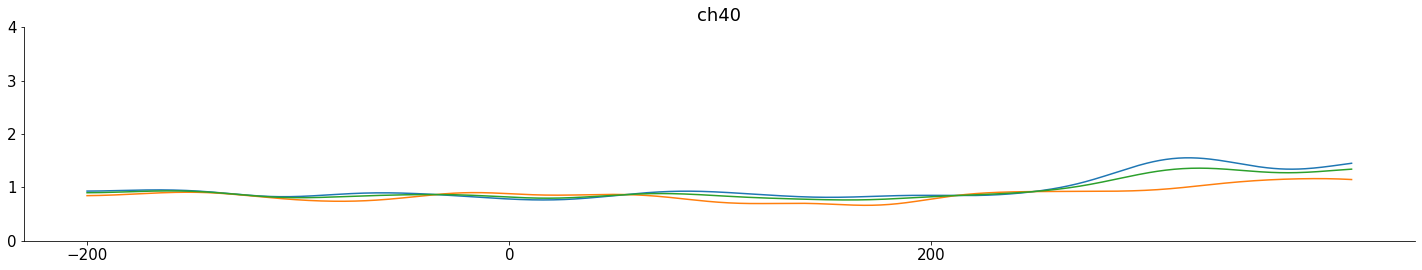

In [30]:
X_noise1_locf.shape
plt.plot(trange, V_face_noise2_f_keyface.mean(axis = 0))
plt.plot(trange, V_face_noise2_f_keyno.mean(axis = 0))
plt.plot(trange, X_noise2_locf.mean(axis = 0))
plt.title('ch40')
plt.xticks([-200, 0, 200])
plt.ylim([0, 4])

In [31]:
# logistic model setting
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

Model = LogisticRegression(penalty="none")

In [32]:
def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.

  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.

  Returns:
    accuracy (float): Proportion of correct predictions.
  """
  y_pred = model.predict(X)

  accuracy = np.mean((y_pred == y))

  return accuracy

In [33]:
# Compute train accurcy for selected loc
X = [X_noise1_locf[:,200:-1],X_noise2_locf[:,200:-1],X_noise3_locf[:,200:-1],X_noise1_loch[:,200:-1],X_noise2_loch[:,200:-1],X_noise3_loch[:,200:-1]]
#X = [X_noise1_locf,X_noise2_locf,X_noise3_locf,X_noise1_loch,X_noise2_loch,X_noise3_loch]
y = [y_noise1_locf,y_noise2_locf,y_noise3_locf,y_noise1_loch,y_noise2_loch,y_noise3_loch]

accuracy_all = []
for i in range(6):
  Model.fit(X[i], y[i])
  accuracy = compute_accuracy(X[i], y[i], Model)
  accuracy_all.append(accuracy)
  print(f"Accuracy on the training data: {accuracy:.2%}")
  #for time in range(400):
    #X_temp = X[i][:,200+time]
    #X_temp = np.array(X_temp).reshape(-1, 1)
    #print(X_temp[0:10])
    #Model.fit(X_temp, y[i])
    #accuracy = compute_accuracy(X_temp, y[i], Model)
    #accuracy_all.append(accuracy)
    #print(f"Accuracy on the training data: {accuracy:.2%}")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Accuracy on the training data: 93.46%
Accuracy on the training data: 78.10%
Accuracy on the training data: 62.14%
Accuracy on the training data: 97.20%
Accuracy on the training data: 70.48%
Accuracy on the training data: 70.87%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[0.9345794392523364, 0.780952380952381, 0.6213592233009708, 0.9719626168224299, 0.7047619047619048, 0.7087378640776699]


(0.5, 1.0)

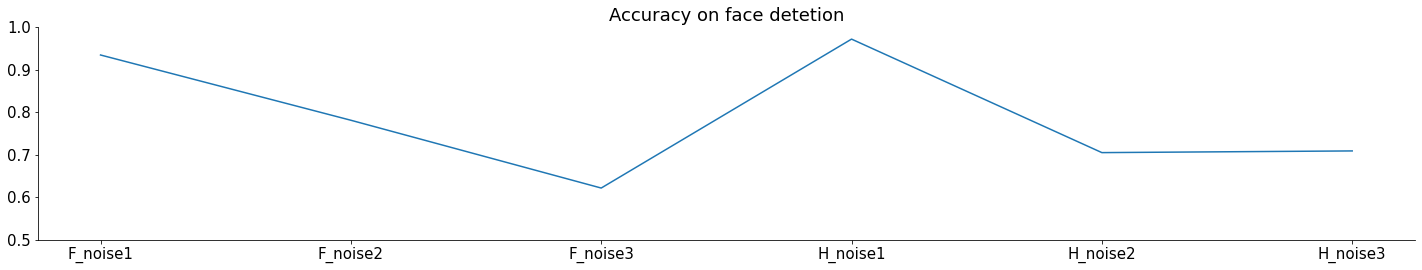

In [34]:
print(accuracy_all)
trange2 = np.arange(0, 6)
plt.plot(trange2, accuracy_all)
plt.title('Accuracy on face detetion')
locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(0, 6, step=1))  # Set label locations.
plt.xticks(np.arange(0,6), ['F_noise1', 'F_noise2', 'F_noise3', 'H_noise1', 'H_noise2', 'H_noise3'])  # Set text labelsplt..
plt.ylim([0.5, 1])

In [ ]:
X = [X_noise1_locf,X_noise2_locf,X_noise3_locf,X_noise1_loch,X_noise2_loch,X_noise3_loch]
y = [y_noise1_locf,y_noise2_locf,y_noise3_locf,y_noise1_loch,y_noise2_loch,y_noise3_loch]
test = X[0]
print(test[100,100])
print(X_noise1_locf[100,100])

0.7823445740014712
0.7823445740014712


In [ ]:
# use L2 regularization
def model_selection(X, y, C_values):
  """Compute CV accuracy for each C value.
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    C_values (1D array): Array of hyperparameter values.
  Returns:
    accuracies (1D array): CV accuracy with each value of C.
  """
  accuracies = []
  for C in C_values:

    # Initialize and fit the model
    # (Hint, you may need to set max_iter)
    model = LogisticRegression(penalty="l2", C=C, max_iter=5000)

    # Get the accuracy for each test split using cross-validation
    accs = cross_val_score(model, X, y, cv=10)

    # Store the average test accuracy for this value of C
    accuracies.append(accs.mean())

  return accuracies


# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)

# Compute accuracies at loc 46
X_46 = X[:,:,46]
accuracies = model_selection(X_46, y, C_values)

print(accuracies)
print(C_values)